In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from denoising_diffusion_pytorch import Unet, GaussianDiffusion
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from datasets import load_dataset
import numpy as np

import utils
import visualize
import metric
import dae
import trainer

### Setting

In [2]:
seed = 42

utils.set_seed(seed)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
### DDPM model setting

batch_size = 128
learning_rate = 1e-3
num_epochs = 5
image_size = 28 # 28 * 28
timesteps = 1000
dim = 64 # Unet latent dimension
channels = 1 # image channel

load_diffusion = True # True if load DDPM weight
diffusion_path = 'model_checkpoint.pth'

In [4]:
### load fashion_mnist dataset
dataset = load_dataset("fashion_mnist")

# define function
transformed_dataset = dataset.with_transform(utils.transform_fuc)#.remove_columns("label")

# create dataloader
dataloader = DataLoader(transformed_dataset["train"], batch_size=batch_size, shuffle=True)

### Model

In [5]:
model = Unet(
    dim = dim,
    dim_mults = (1, 2, 4),
    channels = channels,
    flash_attn = False
).to(device)

diffusion = GaussianDiffusion(
    model,
    image_size = image_size,
    timesteps = timesteps,    # number of steps
    objective = 'pred_noise',
).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [6]:
# load Diffusion model weight (load_diffusion = True)

if load_diffusion:
    checkpoint = torch.load('model_checkpoint.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    diffusion.load_state_dict(checkpoint['diffusion_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Diffusion model Train (load_diffusion = False)

else:
    for epoch in tqdm(range(num_epochs)):
        for step, inputs in enumerate(tqdm(dataloader)):
            optimizer.zero_grad()

            training_images = inputs['pixel_values'].to(device)

            loss = diffusion(training_images)

        if step % 100 == 0:
            print("Loss:", loss.item())
        loss.backward()
        optimizer.step()

    # Save Diffusion model state
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'diffusion_state_dict': diffusion.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }

    torch.save(checkpoint, 'model_checkpoint.pth')

## 1. Choose one User Choice From Real FashionMNIST

2
5
7
9
1


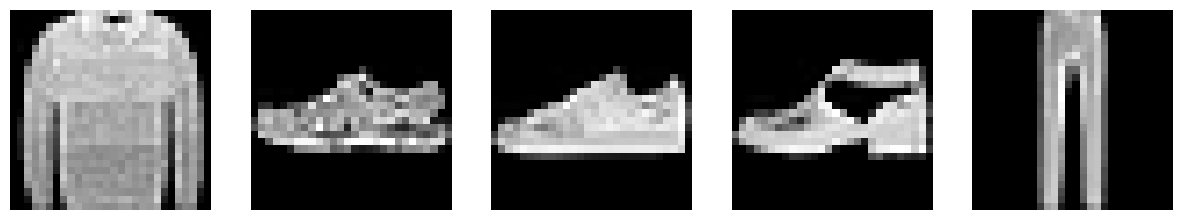

In [7]:
# Choose Images as many as the number of samples

start_idx = 20 
num_samples = 5 # Number of images to visualize

chosen_r_datasets = transformed_dataset['test'][start_idx: start_idx + num_samples]['pixel_values']
chosen_r_labels = transformed_dataset['test'][start_idx: start_idx + num_samples]['label']

visualize.sample_figures(num_samples, chosen_r_datasets, labels=chosen_r_labels)

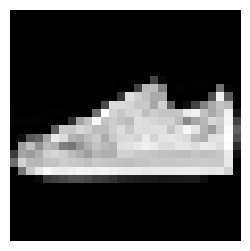

In [8]:
# Select one from the images above (0 ~ num_samples - 1)
chosen_idx = 2
chosen_r_dataset = chosen_r_datasets[chosen_idx]

visualize.sample_figure(dataset = chosen_r_dataset)

## 2. Generate Image From Noise Z

In [9]:
sample_batch_size = 50 # Number of images to generate

# Generate Image
# Repeat until an image similar to the chosen_r_dataset appears.

sampled_images = diffusion.sample(batch_size = sample_batch_size) 
sampled_images.shape # (sample_batch_size, channels, image_size, image_size)

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([50, 1, 28, 28])

## 3. Choose Generated Image similar with chosen from Real data, and regenerate

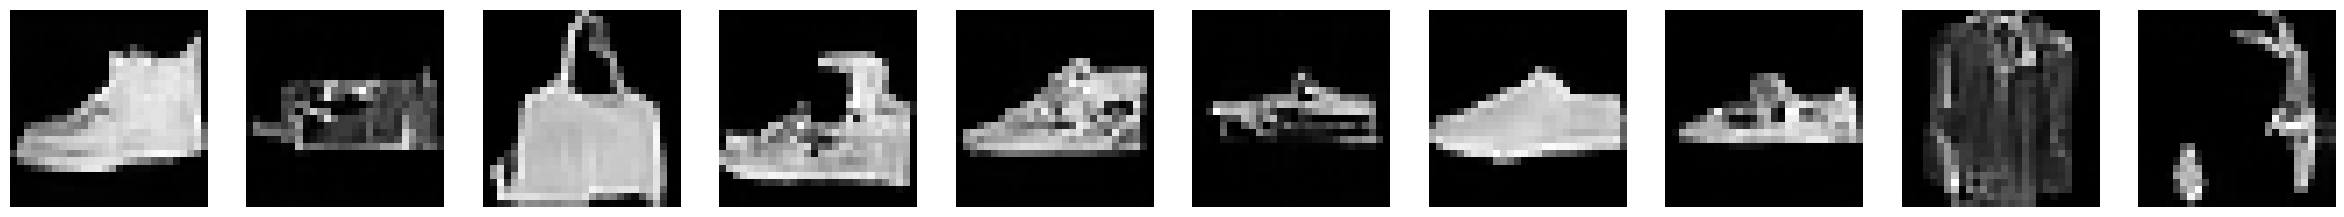

In [10]:
# Generate images as many as sample_batch_size 


start_idx = 20 # 0 ~ (sample_batch_size - num_samples)
num_samples = 10 # Number of images to visualize

chosen_gen_datasets = sampled_images[start_idx:start_idx + num_samples , :, :, :]

# visualize generated items
visualize.sample_figures(num_samples = num_samples, datasets = chosen_gen_datasets)


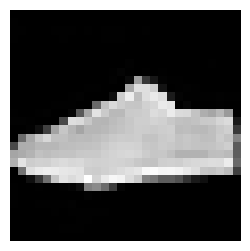

In [11]:
# Choose generated image one from the images above [0, num_samples - 1]
chosen_idx = 6

chosen_gen_dataset = chosen_gen_datasets[chosen_idx] # Select one from the images above (0 ~ num_samples - 1)
normalized_gen_img = chosen_gen_dataset.cpu().apply_(lambda x: (x * 2) - 1) # normalize from [0, 1] to [-1, 1] 

# visualize genearated image similar with user choice
visualize.sample_figure(dataset = normalized_gen_img)

In [12]:
# cosine_sim
gen_cosine_sim, gen_euc = metric.calculate_similarity(normalized_gen_img, chosen_r_dataset)

print(f'cosine_sim: {gen_cosine_sim}') # first generated data cosine similarity
print(f'euclidean_distance: {gen_euc}') # first generated data euclidian distance

cosine_sim: 0.3069506585597992
euclidean_distance: 23.870149612426758


### 4. Regenerate until regenerate image from noise similar to chosen image

In [13]:
t_num = 200
x_start = normalized_gen_img
sample_batch_size = 10 # Number of images to generate

start_index = 0
num_samples = 10

end_index = start_index + num_samples

iterate_num = 10 # diffusion iterate num

max_cosine_sim = gen_cosine_sim

x_list = [x_start]
for i in range(iterate_num):
    cosine_sim = 0 # Initialized to 0 to enter while loop
    
    # Repeat 1 iteration until cosine similarity increases
    while max_cosine_sim > cosine_sim:
        # regenerate image with DDPM
        x_start, x_p, _ = utils.regenerate_image(diffusion, x_start, device, t_num = t_num, batch_size = sample_batch_size) 

        # Select the image with the highest similarity to the user-selected item among DDPM regenerate images.
        x = utils.compare_chosen_generated(start_index, end_index, chosen_r_dataset, x_p, device)

        cosine_sim, euc = metric.calculate_similarity(x, chosen_r_dataset)

        print(f'cosine_sim: {cosine_sim}')
        print(f'euclidean_distance: {euc}')

        # if cosine_similarity increases than previous iteration
        if max_cosine_sim <= cosine_sim:
            print(f'iterate {i + 1}')
            max_cosine_sim = cosine_sim
            x_start = x
            x_list.append(x_start)

100%|██████████| 200/200 [00:09<00:00, 21.51it/s]


cosine_sim: 0.30714166164398193
euclidean_distance: 23.774518966674805
iterate 1


100%|██████████| 200/200 [00:08<00:00, 22.89it/s]


cosine_sim: 0.2949046492576599
euclidean_distance: 23.89878273010254


100%|██████████| 200/200 [00:10<00:00, 19.66it/s]


cosine_sim: 0.294627845287323
euclidean_distance: 23.85042381286621


100%|██████████| 200/200 [00:09<00:00, 20.22it/s]


cosine_sim: 0.2952253818511963
euclidean_distance: 23.809864044189453


100%|██████████| 200/200 [00:10<00:00, 18.82it/s]


cosine_sim: 0.29896727204322815
euclidean_distance: 23.904993057250977


100%|██████████| 200/200 [00:10<00:00, 19.45it/s]


cosine_sim: 0.2972215712070465
euclidean_distance: 23.80095672607422


100%|██████████| 200/200 [00:09<00:00, 21.64it/s]


cosine_sim: 0.29930344223976135
euclidean_distance: 23.868783950805664


100%|██████████| 200/200 [00:10<00:00, 19.63it/s]


cosine_sim: 0.29991114139556885
euclidean_distance: 23.832637786865234


100%|██████████| 200/200 [00:09<00:00, 21.41it/s]


cosine_sim: 0.2910258173942566
euclidean_distance: 23.97089385986328


100%|██████████| 200/200 [00:10<00:00, 19.59it/s]


cosine_sim: 0.3225369453430176
euclidean_distance: 23.802907943725586
iterate 2


100%|██████████| 200/200 [00:10<00:00, 19.36it/s]


cosine_sim: 0.31993216276168823
euclidean_distance: 23.706884384155273


100%|██████████| 200/200 [00:10<00:00, 19.05it/s]


cosine_sim: 0.31996047496795654
euclidean_distance: 23.86583709716797


100%|██████████| 200/200 [00:10<00:00, 19.12it/s]


cosine_sim: 0.31820148229599
euclidean_distance: 23.761491775512695


100%|██████████| 200/200 [00:09<00:00, 20.13it/s]


cosine_sim: 0.3294738531112671
euclidean_distance: 23.7974853515625
iterate 3


100%|██████████| 200/200 [00:09<00:00, 21.81it/s]


cosine_sim: 0.310957670211792
euclidean_distance: 23.948577880859375


100%|██████████| 200/200 [00:08<00:00, 23.63it/s]


cosine_sim: 0.3268813490867615
euclidean_distance: 23.670005798339844


100%|██████████| 200/200 [00:08<00:00, 22.90it/s]


cosine_sim: 0.3266713619232178
euclidean_distance: 23.732131958007812


100%|██████████| 200/200 [00:08<00:00, 23.41it/s]


cosine_sim: 0.301563560962677
euclidean_distance: 23.990684509277344


100%|██████████| 200/200 [00:08<00:00, 22.81it/s]


cosine_sim: 0.3444444537162781
euclidean_distance: 23.70680809020996
iterate 4


100%|██████████| 200/200 [00:08<00:00, 23.06it/s]


cosine_sim: 0.37435176968574524
euclidean_distance: 23.609813690185547
iterate 5


100%|██████████| 200/200 [00:08<00:00, 22.62it/s]


cosine_sim: 0.3570949137210846
euclidean_distance: 23.63519287109375


100%|██████████| 200/200 [00:08<00:00, 23.33it/s]


cosine_sim: 0.3595905601978302
euclidean_distance: 23.705533981323242


100%|██████████| 200/200 [00:08<00:00, 24.05it/s]


cosine_sim: 0.3608560562133789
euclidean_distance: 23.728702545166016


100%|██████████| 200/200 [00:08<00:00, 22.50it/s]


cosine_sim: 0.35498249530792236
euclidean_distance: 23.89873695373535


100%|██████████| 200/200 [00:08<00:00, 22.54it/s]


cosine_sim: 0.3503858149051666
euclidean_distance: 23.72279930114746


100%|██████████| 200/200 [00:09<00:00, 22.13it/s]


cosine_sim: 0.3741263747215271
euclidean_distance: 23.550758361816406


100%|██████████| 200/200 [00:08<00:00, 22.34it/s]


cosine_sim: 0.365676611661911
euclidean_distance: 23.686424255371094


100%|██████████| 200/200 [00:08<00:00, 22.36it/s]


cosine_sim: 0.3697453439235687
euclidean_distance: 23.601184844970703


100%|██████████| 200/200 [00:08<00:00, 23.76it/s]


cosine_sim: 0.37470442056655884
euclidean_distance: 23.615724563598633
iterate 6


100%|██████████| 200/200 [00:08<00:00, 22.98it/s]


cosine_sim: 0.37350812554359436
euclidean_distance: 23.606712341308594


100%|██████████| 200/200 [00:08<00:00, 23.72it/s]


cosine_sim: 0.3651883900165558
euclidean_distance: 23.640722274780273


100%|██████████| 200/200 [00:08<00:00, 22.47it/s]


cosine_sim: 0.35478127002716064
euclidean_distance: 23.783668518066406


100%|██████████| 200/200 [00:08<00:00, 22.83it/s]


cosine_sim: 0.33613255620002747
euclidean_distance: 23.745655059814453


100%|██████████| 200/200 [00:08<00:00, 23.20it/s]


cosine_sim: 0.36233124136924744
euclidean_distance: 23.598220825195312


100%|██████████| 200/200 [00:08<00:00, 22.61it/s]


cosine_sim: 0.36063823103904724
euclidean_distance: 23.646984100341797


100%|██████████| 200/200 [00:08<00:00, 23.59it/s]


cosine_sim: 0.38723912835121155
euclidean_distance: 23.576366424560547
iterate 7


100%|██████████| 200/200 [00:08<00:00, 24.08it/s]


cosine_sim: 0.3736944794654846
euclidean_distance: 23.610456466674805


100%|██████████| 200/200 [00:08<00:00, 23.19it/s]


cosine_sim: 0.38846275210380554
euclidean_distance: 23.51251983642578
iterate 8


100%|██████████| 200/200 [00:08<00:00, 22.97it/s]


cosine_sim: 0.3975144028663635
euclidean_distance: 23.347335815429688
iterate 9


100%|██████████| 200/200 [00:08<00:00, 22.41it/s]

cosine_sim: 0.4296318590641022
euclidean_distance: 23.5660457611084
iterate 10


## 5. denoise with DAE

#### DAE Setting

In [14]:
batch_size = 128 
learning_rate = 1e-3
num_epochs = 5

In [15]:
# dataset

mnist_train = dset.FashionMNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.FashionMNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

dataloaders = {}
dataloaders['train'] = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
dataloaders['test'] = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [17]:
c = 64 # first cnn layer channel
latent_dim = 64 # DAE Encoder output dimension
noise_ratio = 0.1 # DAE added noise ratio

dae_model = dae.DAE_CNN(c, latent_dim).to(device)
dae_optimizer = torch.optim.Adam(dae_model.parameters(), lr=learning_rate)

criterion = nn.BCELoss()

load_DAE = True # True if load DAE weight
dae_path = 'DAE_CNN_checkpoint.pth'

In [18]:
# load DAE model weight (load_DAE = True)

if load_DAE:
    checkpoint = torch.load(dae_path)
    dae_model.load_state_dict(checkpoint['model_state_dict'])
    dae_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# DAE model Train (load_DAE = False)

else:
    # Train DAE
    best_model_high, train_loss_history_high, val_loss_history_high = trainer.train_model(dae_model, dataloaders, criterion, dae_optimizer, device, num_epochs=num_epochs, noise_ratio=noise_ratio)
    
    checkpoint = {
    'model_state_dict': best_model_high.state_dict(),
    'optimizer_state_dict': dae_optimizer.state_dict(),
    }

    torch.save(checkpoint, dae_path)

In [21]:
# Calculate DAE latent vector level similarity between user select image and DDPM output
similarity_list, euc_list = metric.calculate_DAE_similarity(dae_model, chosen_r_dataset, x_list, device)

### Visualize

maximum similarity DDPM iteration: 6


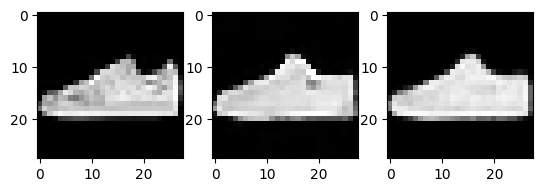

In [22]:
# Visualization of results with highest DAE latent vector level similarity between user select image and DDPM output
denoised_img = visualize.maximum_similarity_result_figure(dae_model, similarity_list, x_list, chosen_r_dataset, device)

Text(0, 0.5, 'Cosine Similarity')

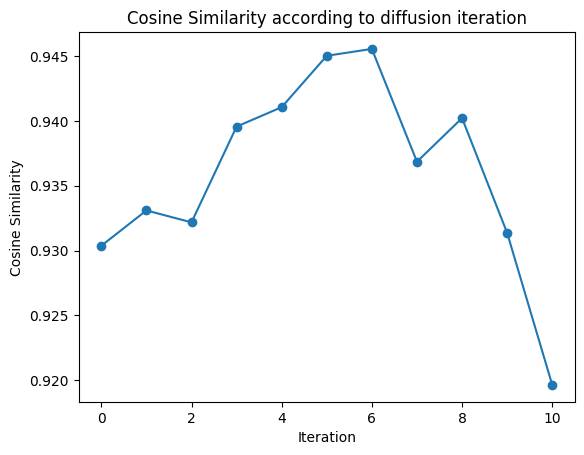

In [23]:
# Visualize DAE latent vector level Cosine similarity between user select image and DDPM output

plt.plot(similarity_list, marker='o')
plt.title('Cosine Similarity according to diffusion iteration')
plt.xlabel('Iteration')
plt.ylabel('Cosine Similarity')

Text(0, 0.5, 'Euclidean Distance')

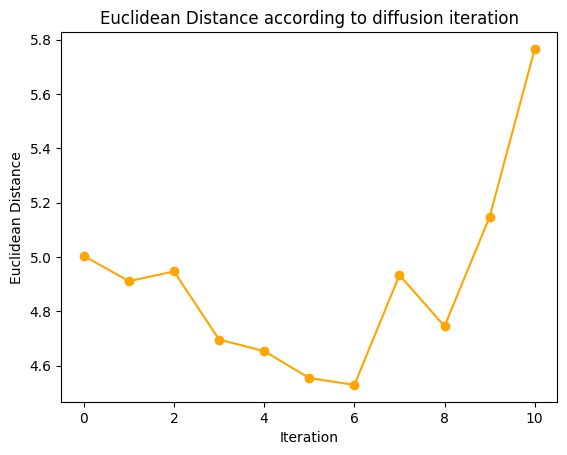

In [24]:
# Visualize DAE latent vector level Euclidean Distance between user select image and DDPM output

plt.plot(euc_list, marker='o', color='orange')
plt.title('Euclidean Distance according to diffusion iteration')
plt.xlabel('Iteration')
plt.ylabel('Euclidean Distance')

### 6. Find near top10 Item with Generated Item

In [25]:
# Dataloader for Find near top10 item

dataloaders['train'] = DataLoader(mnist_train, batch_size=1, shuffle=False)
dataloaders['test'] = DataLoader(mnist_test, batch_size=1, shuffle=False)

In [26]:
# Similarity is calculated only for items with the same label as the user-selected item

label_num = 7

real_image_list, real_similarity_list, real_euc_list = metric.calculate_real_similarity(dataloaders, dae_model, denoised_img, noise_ratio, device, label_num)

100%|██████████| 60000/60000 [00:23<00:00, 2564.95it/s]


In [27]:
# Select the top 10 real image indices with the highest cosine similarity to the generated image.

top_10_indexes = utils.top_n_indexes(real_similarity_list, 10)

result_top10_list = real_image_list[top_10_indexes] # real top10 image

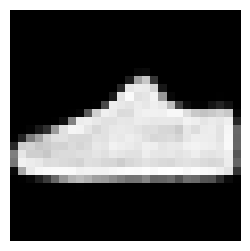

In [30]:
# Visualize Genearated Image
visualize.sample_figure(denoised_img)

Top 1 Cosine similarity : 0.9553475379943848
Top 2 Cosine similarity : 0.9549223184585571
Top 3 Cosine similarity : 0.9541723728179932
Top 4 Cosine similarity : 0.9525436758995056
Top 5 Cosine similarity : 0.9503309726715088
Top 6 Cosine similarity : 0.9500746726989746
Top 7 Cosine similarity : 0.9496303796768188
Top 8 Cosine similarity : 0.9491622447967529
Top 9 Cosine similarity : 0.9470489025115967
Top 10 Cosine similarity : 0.9446926712989807


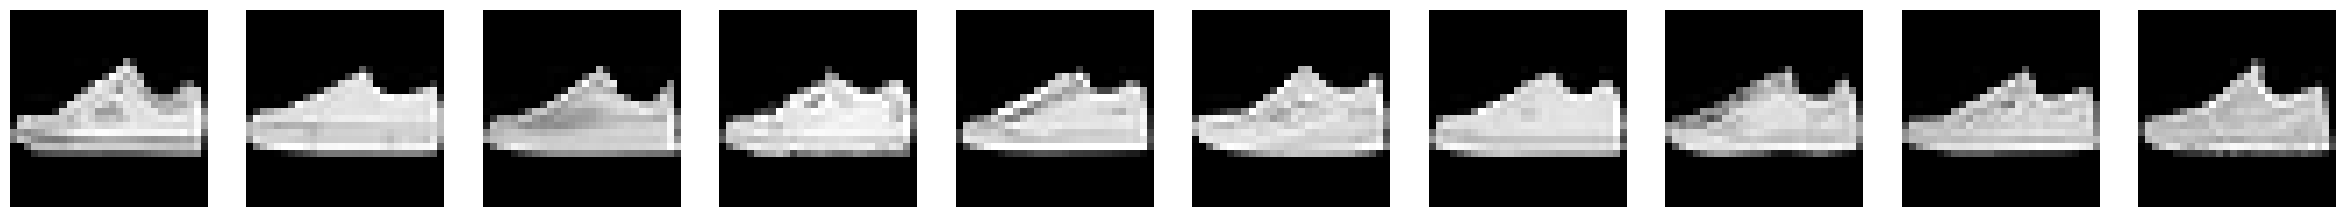

In [31]:
# Visualization of the 10 real items with the highest similarity to the Generated Image at the DAE latent vector level

# Top 10 Cosine Similarity Indexing
cos_top10_list = np.array(real_similarity_list)[top_10_indexes]

# Print Top 10 Cosine similarity
for i, cosine in enumerate(cos_top10_list):
    print(f'Top {i + 1} Cosine similarity : {cosine}')

visualize.sample_figures(10, result_top10_list)